In [1]:
from fun.selection_of_ROIs import *

import warnings
warnings.filterwarnings("ignore")

## 1. Specify the folders that will be processed and clean them (remove precedent processing results)

In [2]:
0/0
# 1. select all the fresh measurements
# data_folder_path = './data/fixation_over_time'
data_folder_path = './data/fixation_over_time'

path_folder_temp = './temp'
path_align_folder = './alignment/to_align'
base_dirs = []

for folder in os.listdir(data_folder_path):
    if 'T0_' in folder:
        base_dirs.append(os.path.join(data_folder_path, folder))
        
    # 2. remove previously acquired data to allow the selection of new ROIs
    path_results = os.path.join(data_folder_path, folder, 'polarimetry/550nm/50x50_images')
    for filename in os.listdir(path_results):
        file_path = os.path.join(path_results, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))
                
# 3. clean the alignment folder
for fname in os.listdir(path_align_folder):
    file_path = os.path.join(path_align_folder, fname)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

## 2. Loop over all the folders that will be processed

#### 2.1. set global variables (such as the number of squares)

In [3]:
# to perform propagation
# number_of_random_squares = 25
number_of_random_squares = 25
fixation = True
wavelength = '550'
square_size = 20
square_number = 1
type_rec_sq = 'square'

# for the propagation data collection
new_folder_names = ['-T0-D12_', '-T0-D24_', '-T0-D36_', '-T0-D48_', '-T0-D7d_']
new_dates = ['2022-05-03', '2022-05-03', '2022-05-04', '2022-05-04', '2022-05-11']
old_folder_name = '-T0_'
old_date = '2022-05-02'

#### 2.2. loop over all the folders that needs to be processed

100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [1:00:56<00:00, 914.09s/it]


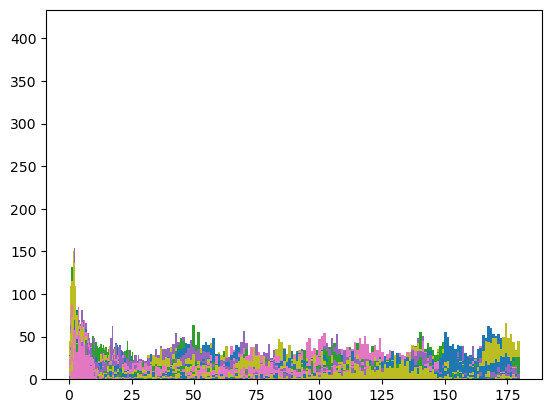

In [4]:
# tissue_types = ['WM', 'GM']
tissue_types = ['WM', 'GM']
for path_folder in tqdm(base_dirs):
    for tissue_type in tissue_types:
        
        # 1. set up the parameters and load the Mueller Matrix
        WM = tissue_type == 'WM'
        mask_matter, grid = get_mask_matter_and_grid(path_folder, tissue_type)
        MM_maps = load_data_mm(path_folder, wavelength)[:-1]
        mat = load_data_mm(path_folder, wavelength)[-1]
        path_folder_50x50 = path_folder + '/polarimetry/' + str(wavelength) + 'nm/50x50_images/'
        folder_name = path_folder.split('\\')[-1]
        if WM:
            new_folder_name = 'WM_1'
        else:
            new_folder_name = 'GM_1'
        propagated = False
        
        # 2. automatic selection and preparation for the propagation of the ROIs
        propagation_list = square_selection(path_folder_temp, path_folder, path_folder_50x50, folder_name, wavelength, 
                     number_of_random_squares, square_size, type_rec_sq, WM, mask_matter, grid, 
                     MM_maps, mat)
        
        
        # 3. actually do the alignment
        propagation_list = generate_combined_mask(propagation_list)
        do_alignment()
        output_folders = move_computed_folders()
        
        # 4. and collect the data after propagation
        collect_data_propagated(WM, new_folder_names, new_dates, old_folder_name, old_date, path_folder, 
                        propagation_list, output_folders)